# Exercice 1 - Visualisation et filtrage du signal ECG

## 1.1 Affichage d'un segment normal

### Preparation de l'environement

On utilise la bibliotheque wfdb qui nous permet d'acceder aux donnes sans telecharger la librairie des signes en question. On l'install via pip.

In [1]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.


### 1) Récupération des données et affichage
On utilise wfdb.rdsamp pour récupérer les données. Selon la documentation de la fonction rdsamp, nous avons wfdb.rdsamp(record_name, sampfrom=0, sampto=None, channels=None, pn_dir=None, channel_names=None, warn_empty=False, return_res=64) tel que :

* record_name str: The name of the WFDB record to be read (without any file extensions). If the argument contains any path delimiter characters, the argument will be interpreted as PATH/baserecord and the data files will be searched for in the local path.
* pn_dir str: Option used to stream data from Physionet. The Physionet database directory from which to find the required record files. eg. For record '100' in 'http://physionet.org/content/mitdb' pn_dir='mitdb'.

Tous les autres arguments ne sont pas intéressants pour notre application. On sait que ça va retourner un array 2D, le signal en format brut et sa fréquence.

### 2) Affichage de la deuxième segment d'une minute pour ce signal ECG
On sait que la fréquence est 100 Hz et une minute est 60 secondes, donc on aura 60 * 100 = 6000 points de données pour cette représentation. Donc nous sommes intéressés par les données entre 6000 et 11999. Niveau graphique, sur l'axe X nous avons le temps et sur l'axe Y nous avons les données.

### 3) Récupérer l'annotation par la base de données
On sait que toutes les annotations sont dans les fichiers sous le nom *.apn. Il existe une fonction dans la librairie wfdb qui peut extraire directement l'annotation pour nous à partir de ce fichier. Il s'agit de la fonction wfdb.rdann. Ça va nous retourner une liste dans laquelle nous avons des symboles chaque 1 minute. Nous sommes en deuxième minute, donc on cherche symbol[1] car l'élément 1 est l'élément 0 en Python. Donc, l'élément 2 (deuxiéme minute) est l'élément 1 en python.

Frequency (echantillonage): 100 Hz


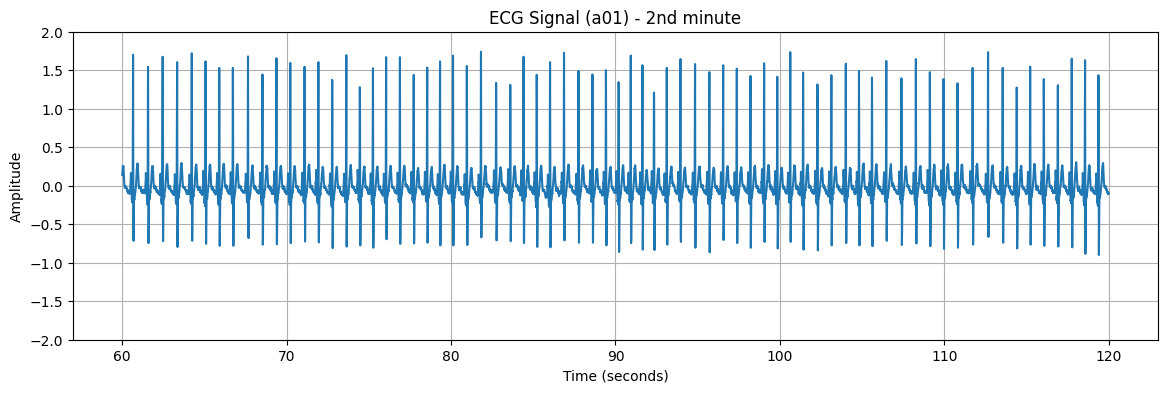

Annotation for the second minute: N
This segment is normal


In [2]:
import wfdb

# 1) PhysioNet via wfdb.rdsamp
record = wfdb.rdsamp('a01', pn_dir='apnea-ecg/1.0.0')
signal = record[0] 
fs = record[1]['fs']
print(f"Frequency (echantillonage): {fs} Hz") # 100 Hz selon la documentation du TP - verification

import numpy as np

# 2) Affichage la deuxieme segment d'une minute pour ce signal ECG
start_data = 60 * fs  # debut 6000 point
end_data = 2 * 60 * fs - 1  # fin 11999 point (voir noets ci-dessus)
extracted_signal = signal[start_data:end_data + 1, 0]
time = np.arange(start_data, end_data + 1) / fs # en seconds

import matplotlib.pyplot as plt

# Plot de la figure en question
plt.figure(figsize=(14, 4))
plt.plot(time, extracted_signal)
plt.title('ECG Signal (a01) - 2nd minute')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.ylim(-2.0, 2.0)
plt.show()

# 3) Recuperer l'annotation par la base des donnees
annotations = wfdb.rdann('a01', 'apn', pn_dir='apnea-ecg/1.0.0')
second_minute_annotation = annotations.symbol[1]  # voir le commentaire ci-dessus pour le choix du nombre [1]

print(f"Annotation for the second minute: {second_minute_annotation}")
print(f"This segment is {'apneic' if second_minute_annotation == 'A' else 'normal' if second_minute_annotation == 'N' else 'corrected'}")

## 1.2 Parcourir les annotations pour trouver le premier épisode d'apnée
On va parcourir la liste des annotations pour trouver la première occurrence de A => Apnée détectée par les experts puis on utilise la même méthode que dans la partie 1.1 pour visualiser le signal ECG.

First apnea episode found at minute 14


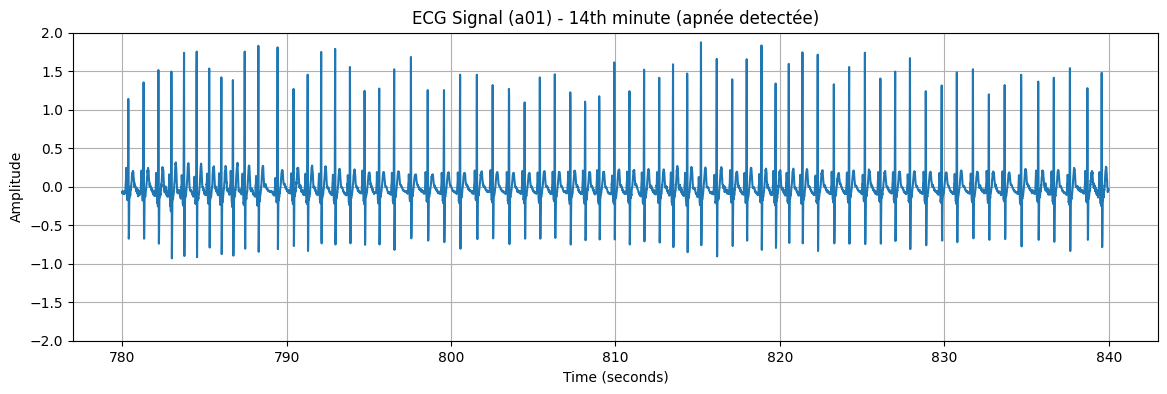

In [3]:
for i, symbol in enumerate(annotations.symbol):
    if symbol == 'A':
        print(f"First apnea episode found at minute {i + 1}")
        break

# Affichage du segment detecté
start_data_apnee = i * 60 * fs  # meme logique que ci-dessus pour le deucieme minute
end_data_apnee = (i + 1) * 60 * fs - 1
extracted_signal_apnee = signal[start_data_apnee:end_data_apnee + 1, 0]
time = np.arange(start_data_apnee, end_data_apnee + 1) / fs  # c'est en secondes

# Plot de la figure en question
plt.figure(figsize=(14, 4))
plt.plot(time, extracted_signal_apnee)
plt.title(f'ECG Signal (a01) - {i + 1}th minute (apnée detectée)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.ylim(-2.0, 2.0)
plt.grid(True)
plt.show()


### Observations

Par rapport à la figure de la seconde minute où l'apnée du sommeil n'est pas détectée (état normal), on observe que la fréquence entre les pics R est régulière et constante, ce qui est un bon indicateur que nous ne sommes pas dans un état anormal. Cependant à la minute 14 où l'apnée du sommeil est détectée, on peut observer un effet d'oscillation entre les différentes valeurs du signal QRS (comme si on avait une tachycardie et une bradycardie, on a des périodes d'accélération et de ralentissement du rythme cardiaque bien visibles). En ce qui concerne l'amplitude du pic R, il semble que dans les deux cas nous avons des amplitudes similaires, mais la durée du signal QRS (espacement temporel) n'est pas très constante.

## 1.3 Application d'un filtre passe-bande Butterworth

### 1) Appliquez un filtre Butterworth

On va appliquer un filtre passe-bande Butterworth d'ordre 4. Tous ses pôles sont sur le cercle unité, ce qui va permettre le passage de fréquences entre 0,1 et 35 Hz tout en atténuant les fréquences en dehors de cette plage.

Pour notre analyse, la variable extracted_signal_apnee (du code ci-dessus) contient les données du signal à la 14ème minute (apnée détectée), tandis que extracted_signal contient les données du signal à la 2ème minute.

Signal before filtering:


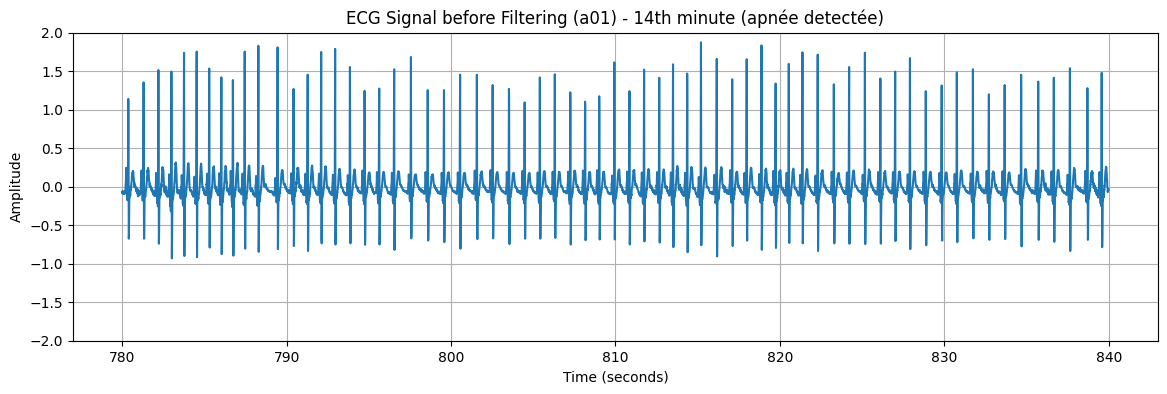

Signal after filtering:


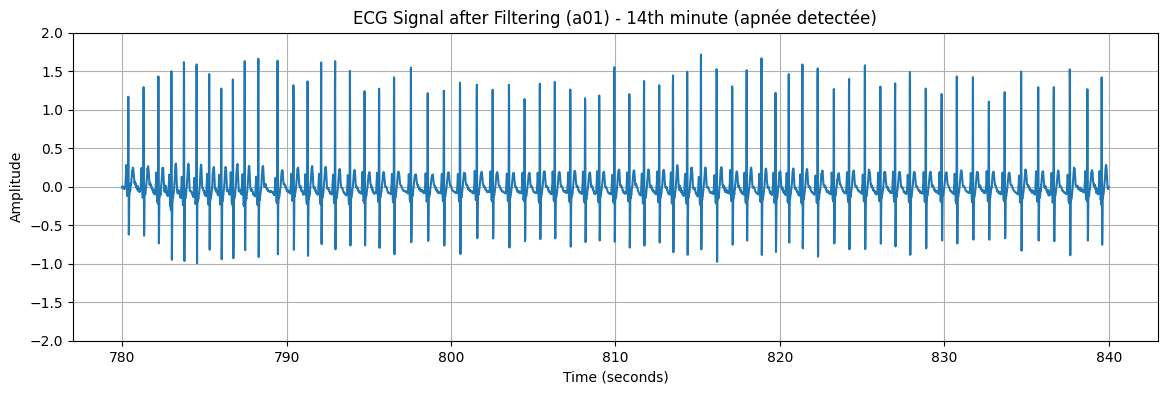

In [4]:
from scipy import signal

# Creation du fiiltre passe-bande
order = 4
fc_start = 0.1
fc_end = 35
nyq = 0.5 * fs # normalisation de frequences en utilisant la frequence de Nyquist selon le cours
low = fc_start / nyq
high = fc_end / nyq
b, a = signal.butter(order, [low, high], btype='bandpass')

def apply_filter(signal_data, b, a):
    return signal.filtfilt(b, a, signal_data)

# Observant la distorsion avec l'affichage du signal avec un plot avant et apres le filtrage
print("Signal before filtering:")
plt.figure(figsize=(14, 4))
plt.plot(time, extracted_signal_apnee)
plt.title(f'ECG Signal before Filtering (a01) - {i + 1}th minute (apnée detectée)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.ylim(-2.0, 2.0)
plt.grid(True)
plt.show()  

filtered_signal = apply_filter(extracted_signal_apnee, b, a)
print("Signal after filtering:")
plt.figure(figsize=(14, 4))
plt.plot(time, filtered_signal)
plt.grid(True)
plt.title(f'ECG Signal after Filtering (a01) - {i + 1}th minute (apnée detectée)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.ylim(-2.0, 2.0)
plt.show()

**La superposition des signaux filtrés est disponible sur la question suivante pour faire une analyse sur mesure**. On peut observer une distorsion au début ou à la fin du signal avant le filtrage, surtout si on observe le premier et le dernier pic qui ne sont pas très réguliers par rapport aux autres pics similaires.

Pour dépasser cet effet, on procède avec la méthode de zero-padding qui consiste à rajouter des zéros à la fin et au début du signal avant de faire l'analyse spectrale. Le zero-padding est fait par defaut quand on applique filtfilt qui elimine aussi le déphasage. De base, le zero-padding va provoquer une prolongation artificielle du signal qui lutte contre cet effet de distorsion. Les resultats sont disponibles ci-dessous.

## 2/3) Réponses aux questions d'analyse

### Méthode

On va superposer le signal avant filtrage avec le signal après filtrage et padding pour essayer de répondre aux questions suivantes :

1) Observez et expliquez comment le filtrage clarifie le signal
2) Observez et expliquez comment le filtrage modifie la position ou la forme des pics R

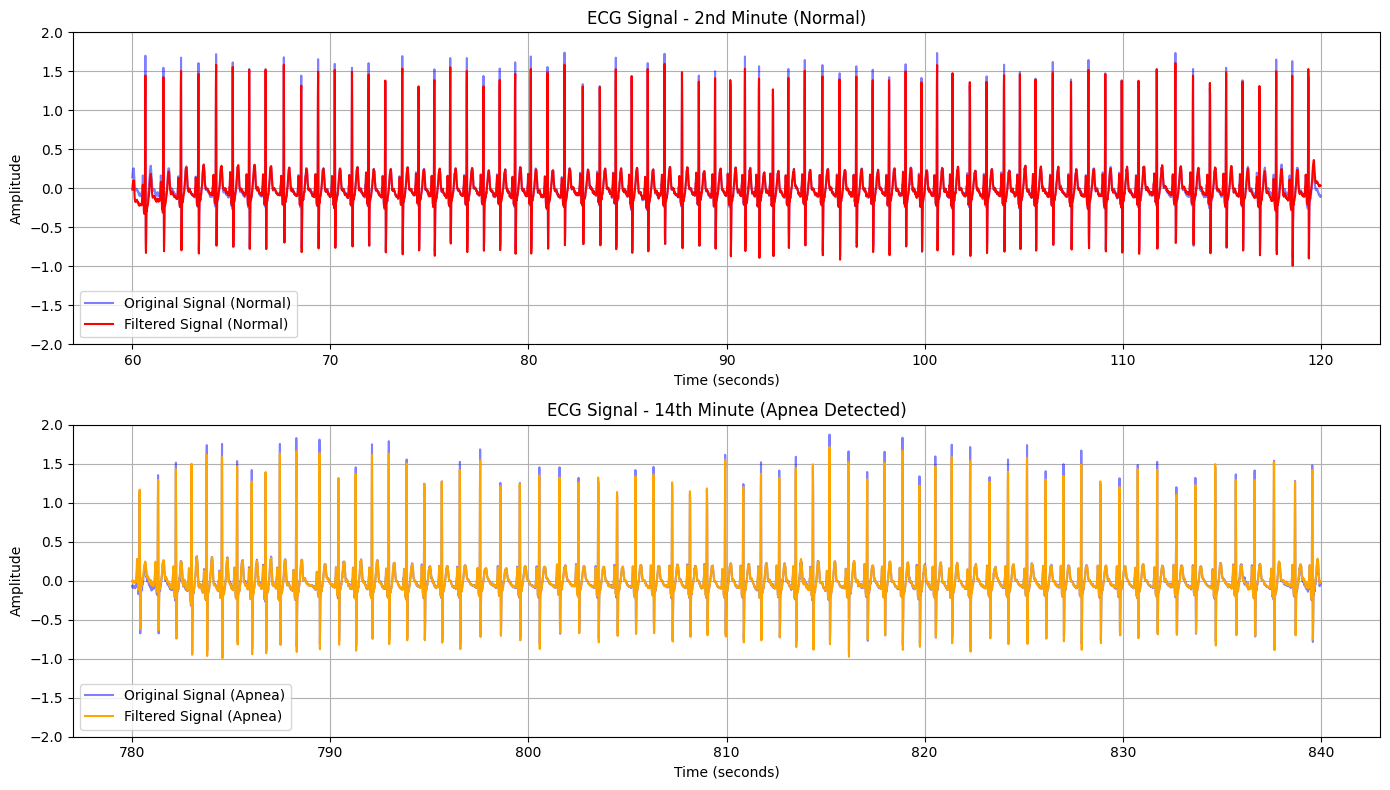

In [5]:
# Renomage des variables pour avoir une meilleure comprehension
filtered_normal = apply_filter(extracted_signal, b, a)
filtered_apnea = filtered_signal

# vecteur du temps pour les deux signaux
time_normal = np.arange(len(extracted_signal)) / fs + 60  # Second minute starts at 60s
time_apnea = np.arange(len(extracted_signal_apnee)) / fs + i * 60  # Apnea minute starts at i*60s

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1) # 2 lignes - 1 colonne (caracteristiques de plot)
plt.plot(time_normal, extracted_signal, label='Original Signal (Normal)', alpha=0.5, color='blue')
plt.plot(time_normal, filtered_normal, label='Filtered Signal (Normal)', color='red')
plt.title('ECG Signal - 2nd Minute (Normal)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.ylim(-2.0, 2.0)

plt.subplot(2, 1, 2)
plt.plot(time_apnea, extracted_signal_apnee, label='Original Signal (Apnea)', alpha=0.5, color='blue')
plt.plot(time_apnea, filtered_apnea, label='Filtered Signal (Apnea)', color='orange')
plt.title(f'ECG Signal - {i + 1}th Minute (Apnea Detected)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.ylim(-2.0, 2.0)
plt.tight_layout()
plt.show()


### Analyse

On observe que le signal filtré avec padding est plus stabilisé par rapport au signal non filtré. Concernant les pics R, ils conservent leur position temporelle grâce à la fonction filtfilt qui évite les effets du déphasage. De plus, on observe que l'amplitude de ces pics est réduite (signal filtré) par rapport au signal de base.

## 1.4 Fréquence d'échantillonnage

Selon le théorème de Nyquist, la fréquence d'échantillonnage doit être au moins deux fois supérieure à la fréquence maximale dans le signal. Donc, on peut proposer de prendre une fréquence d'échantillonnage de 200 Hz avant le filtrage.

Maintenant, nous avons appliqué un filtre avec une frequence de coupure de 0,1 à 35 Hz. Donc selon Nyquist, la frequence minimal faut etre 2 x 35 = 70 Hz.

# Exercice 2 - Extraction de caractéristiques HRV

## 2.1 Importance des caractéristiques

Dans ce deuxième exercice, on va extraire des caractéristiques du rythme cardiaque comme le HRV (Heart Rate Variability) à partir du signal ECG qu'on peut utiliser pour une classification automatique pour la détection d'apnée du sommeil. Notre objectif est d'avoir des caractéristiques qu'on peut introduire dans un algorithme, car de base le signal ECG contient des milliers de points de données par segment, et ça n'est pas très efficace au niveau de la complexité computationnelle pour le ou les algorithmes choisis.

De plus, un signal ECG contient trop de bruit et de redondance, ce qui pourrait impacter l'apprentissage de l'algorithme pour la détection de l'apnée du sommeil. Dans notre cas, le HRV capture spécifiquement les patterns physiologiques significatifs dont on peut se servir pour un entraînement plus ciblé et contrôlé. De cette manière, vu que le système se base sur des informations pertinentes, les cliniciens peuvent comprendre les décisions du modèle et identifier les biomarqueurs les plus discriminants entre l'état normal et l'état apnéique. En d'autres termes, l'algorithme peut facilement identifier les frontières de décision en comparaison à ce qui se passerait si on donnait les données brutes.

**Nota bene :** Un enregistrement HRV est très long, donc il existe un fort intérêt à appliquer différentes méthodes de détection d'apnée car pour un clinicien, il serait trop fastidieux et chronophage d'analyser manuellement l'intégralité des données.

## 2.2 Extraction des pics R

### Préparation

On va installer la bibliothèque biosppy qui va nous permettre la détection de pics R. La bibliothèque biosppy dépend aussi de la bibliothèque peakutils qui n'était pas téléchargée automatiquement.

In [6]:
pip install biosppy

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install peakutils

Note: you may need to restart the kernel to use updated packages.


On va tracer les signaux de l'exercice 1, filtrés avec padding à la 2ème et à la 14ème minute, mais on va appliquer l'algorithme de détection de QRS de Hamilton qui nous permettra de tracer dans le même plot les pics R marqués par des points.

Une correction est nécessaire pour supprimer les faux positifs et assurer le positionnement des pics avec précision.

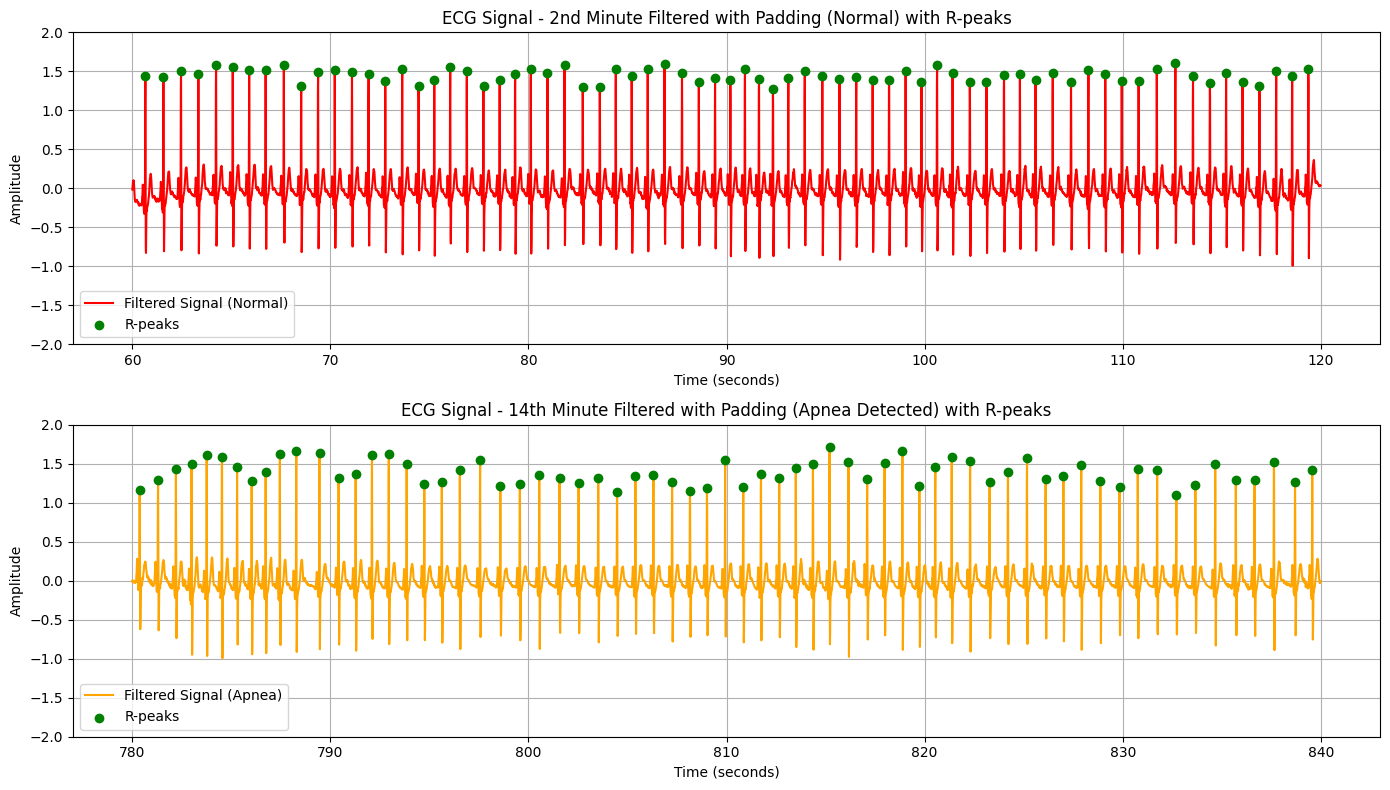

In [8]:
from biosppy.signals.ecg import hamilton_segmenter, correct_rpeaks

# Extraction des R-peaks avec la librairie biosppy
rpeaks_normal, = hamilton_segmenter(filtered_normal, sampling_rate=fs)
rpeaks_apnea, = hamilton_segmenter(filtered_apnea, sampling_rate=fs)
rpeaks_normal = correct_rpeaks(filtered_normal, rpeaks_normal, sampling_rate=fs)
rpeaks_apnea = correct_rpeaks(filtered_apnea, rpeaks_apnea, sampling_rate=fs)

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(time_normal, filtered_normal, label='Filtered Signal (Normal)', color='red')
plt.scatter(time_normal[rpeaks_normal], filtered_normal[rpeaks_normal], color='green', label='R-peaks', zorder=5)
plt.title('ECG Signal - 2nd Minute Filtered with Padding (Normal) with R-peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.ylim(-2.0, 2.0) 

plt.subplot(2, 1, 2)
plt.plot(time_apnea, filtered_apnea, label='Filtered Signal (Apnea)', color='orange')
plt.scatter(time_apnea[rpeaks_apnea], filtered_apnea[rpeaks_apnea], color='green', label='R-peaks', zorder=5)
plt.title(f'ECG Signal - {i + 1}th Minute Filtered with Padding (Apnea Detected) with R-peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.ylim(-2.0, 2.0)
plt.tight_layout()
plt.show()



## 2.3 Caractéristiques HRV

Il y a plusieurs caractéristiques HRV qu'on va extraire. Toutes dépendent du segment R-R, et c'est la raison pour laquelle la détection de ces pics était essentielle dans la question précédente. Voici les différentes caractéristiques qui nous intéressent :

### Les caractéristiques

#### Caractéristiques temporelles (Time-domain)

Ces caractéristiques sont directement calculées à partir des intervalles R-R (en millisecondes) :

* SDNN : écart-type des intervalles R-R (variabilité globale)
* RMSSD : racine carrée de la moyenne des carrés des différences successives
* SDSD : écart-type des différences successives
* pNN50 : pourcentage de paires d'intervalles R-R dont la différence est supérieure à 50 ms

#### Caractéristiques fréquentielles (Frequency-domain)

Ces caractéristiques sont obtenues par une analyse spectrale des intervalles R-R, à partir de la densité spectrale de puissance (PSD) estimée via la méthode de Welch ou une transformée de Fourier rapide (FFT) :

* Total Power : puissance totale du spectre HRV
* VLF : puissance dans la bande très basse fréquence (0–0.04 Hz)
* LF : puissance dans la bande basse fréquence (0.04–0.15 Hz)
* HF : puissance dans la bande haute fréquence (0.15–0.4 Hz)

### Préparation

On va utiliser la bibliothèque hrvanalysis que l'on installe ci-dessous. Cette bibliothèque est disponible via le projet AURA et la documentation concernant l'installation est disponible sur https://github.com/Aura-healthcare/hrv-analysis

In [9]:
pip install hrv-analysis

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install opencv-python==4.8.1.78

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install astropy==5.3.4

Note: you may need to restart the kernel to use updated packages.


Notre objectif est de trouver les caractéristiques en question via get_time_domain_features() et get_frequency_domain_features(). Puis on va comparer les deux segments et interpréter les différences observées.

Il faut transformer la liste de rpeaks en rr_intervals car le fonction get_time_domain_features() peut accepter que des intervales du temps en millisecondes. Pour faire cela, nous avons:

* temps_secondes = echantillons / fs
* temps_millisecondes = temps_secondes * 1000

In [12]:
from hrvanalysis import get_time_domain_features, get_frequency_domain_features

# R pics vers RR intervals
def get_rr_intervals(rpeaks, fs):
    rr_intervals = np.diff(rpeaks) * (1000 / fs)
    return rr_intervals.flatten().tolist() # liste en 1D pour avec le temps de division des intervalles

rr_intervals_normal = get_rr_intervals(rpeaks_normal, fs)
rr_intervals_apnea = get_rr_intervals(rpeaks_apnea, fs)

# Verification des resultats
print(f"Normal segment: {len(rr_intervals_normal)} RR intervals")
# print(f"First few normal RR intervals: {rr_intervals_normal[:5]}")

print(f"Apnea segment: {len(rr_intervals_apnea)} RR intervals")
# print(f"First few apnea RR intervals: {rr_intervals_apnea[:5]}")

/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/nolds/datasets.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Normal segment: 70 RR intervals
Apnea segment: 65 RR intervals


Maintenant on essaye d'extraire les caractéristiques HRV via hrvanalysis. Le retour des fonctions get_time_domain_features() et get_frequency_domain_features() sont des dictionnaires qui contiennent les caractéristiques en question.

In [13]:
import pandas as pd

try:
    time_domain_normal = get_time_domain_features(rr_intervals_normal)
    time_domain_apnea = get_time_domain_features(rr_intervals_apnea)
    freq_domain_normal = get_frequency_domain_features(rr_intervals_normal)
    freq_domain_apnea = get_frequency_domain_features(rr_intervals_apnea)

    # Combine all features for normal and apnea segments
    all_features_normal = {**time_domain_normal, **freq_domain_normal}
    all_features_apnea = {**time_domain_apnea, **freq_domain_apnea}

    # Impression de tous les valeurs pour les deux signaux (caracteristiques temporelles et frequencielles)
    comparison_df = pd.DataFrame({
        'Feature': list(all_features_normal.keys()),
        'Normal Segment (2nd min)': [f"{val:.4f}" if isinstance(val, (int, float)) else val 
                                    for val in all_features_normal.values()],
        'Apnea Segment (14th min)': [f"{val:.4f}" if isinstance(val, (int, float)) else val 
                                   for val in all_features_apnea.values()]
    })

    # Affichage du tableau avec tous les donnees
    print("\nHRV Features Comparison:")
    print(comparison_df.to_string(index=False))

    print("\nKey Differences Analysis:")
    for feature in ['sdnn', 'rmssd', 'sdsd', 'pnn_50', 'total_power', 'vlf', 'lf', 'hf']:
        if feature in all_features_normal and feature in all_features_apnea:
            normal_val = all_features_normal[feature]
            apnea_val = all_features_apnea[feature]
            diff_pct = ((apnea_val - normal_val) / normal_val * 100) if normal_val != 0 else 0
            print(f"{feature:12}: Normal={normal_val:.3f}, Apnea={apnea_val:.3f}, Diff={diff_pct:+.1f}%")

except Exception as e:
    print(f"Error processing HRV features: {e}")
    print("RR intervals might have invalid values or incorrect format")


HRV Features Comparison:
    Feature Normal Segment (2nd min) Apnea Segment (14th min)
   mean_nni                 838.7143                 910.7692
       sdnn                  46.3735                  85.0424
       sdsd                  38.7588                  74.8899
     nni_50                        9                       18
    pnni_50                  13.0435                  28.1250
     nni_20                       38                       41
    pnni_20                  55.0725                  64.0625
      rmssd                  38.7859                  74.8958
 median_nni                 840.0000                 920.0000
  range_nni                 240.0000                 470.0000
       cvsd                   0.0462                   0.0822
      cvnni                   0.0553                   0.0934
    mean_hr                  71.7612                  66.4680
     max_hr                  85.7143                  85.7143
     min_hr                  63.8298        

/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/hrvanalysis/extract_features.py:339: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 232, using nperseg = 232
  freq, psd = signal.welch(x=nni_normalized, fs=sampling_frequency, window='hann',
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/hrvanalysis/extract_features.py:339: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 234, using nperseg = 234
  freq, psd = signal.welch(x=nni_normalized, fs=sampling_frequency, window='hann',


### Conclusion

Le segment apnée montre une augmentation de tous les indices de variabilité temporelle. Le SDNN augmente de 83,4 % (46,4 -> 85,0 ms), tandis que le RMSSD et le SDSD augmentent tous les deux d'environ 93 % (38,8 -> 74,9 ms). En parallel de cette hypervariabilité on observe un doublement du pourcentage d'intervalles successifs variant de plus de 50 ms (pNN50 : 13 % > 28 %). Contrairement à ce qu'on pourrait penser, cette augmentation de variabilité n'est pas un signe de bonne santé cardiovasculaire mais reflète plutôt les oscillations cycliques pathologiques caractéristiques de l'apnée selon le cours.

Si on se focalise sur les caractéristiques frequentielles, les caractéristiques LF et HF sont diminué (-29,1 % et -18,5 % respectivement) malgré l'augmentation de la variabilité globale. À noter aussi que le ratio LF/HF diminue (1,57 -> 1,37), et selon le cours ca pourrait sugerer un déplacement vers une dominance parasympathique pendant les épisodes d'apnée. En conclusion, on peut dire que l'hypervariabilité observée reflète un stress cardiovasculaire répété plutôt qu'une adaptation physiologique saine.

# Exercice 3 - Conception d’un classifieur MLP

## Introduction

Nous avons un fichier nommé features_apnea.csv qui contient une ligne par segment ECG (1 minute), une colonne par caractéristique HRV et une colonne label contenant les classes (0 = normal, 1 = apnée). Notre objectif est d'utiliser un MLP pour classifier automatiquement les segments du sommeil entre normal et apnée.

## 3.1 Chargement et division du jeu de données

On va utiliser pandas pour charger le fichier .csv, puis on va créer nos composantes pour le perceptron MLP, c'est-à-dire le vecteur des caractéristiques utilisé par le perceptron (X) qui correspond bien aux caractéristiques identifiées à l'exercice 2 ['sdnn', 'rmssd', 'sdsd', 'pnn_50', 'total_power', 'vlf', 'lf', 'hf'], ainsi que le vecteur des étiquettes (Y).

Nous avons besoin de diviser la base de données en 3 sections :

* Base d’apprentissage : pour apprendre le modèle
* Base de validation : pour aider à définir certains paramètres du modèle
* Base de test : pour tester le modèle sur de nouvelles données jamais rencontrées

Ici on procède avec 70 % pour l'entraînement, 15 % pour la validation et 15 % pour le test. Dans un premier temps, on va prendre 15 % de notre base de données originale pour le test. Puis on veut 15 % des 85 % restants pour la validation et ce qui reste est pour l'entraînement.

### Préparation

On utilise sklearn car on aura besoin de ses fonctions pour la réalisation du modèle MLP. On utilise train_test_split de sklearn.model_selection avec l'option stratify=y pour garantir une répartition équilibrée des classes dans chaque ensemble. Il faut installer cette librairie si ce n'est pas déjà fait.

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features_df = pd.read_csv('features_apnea.csv') # en utilisant pandas

# Affichage quelques donnes pour verifier la structure du fichier CSV
print("Dataset overview:")
print(features_df.head())
print(f"Shape: {features_df.shape}")
print(f"Class distribution: {features_df['label'].value_counts().to_dict()}")

X_features = ['sdnn', 'rmssd', 'sdsd', 'range_nni', 'pnni_50','pnni_20', 'total_power', 'min_hr','nni_20','median_nni','min_hr','vlf', 'lf', 'hf', 'perm', 'lf_hf_ratio', 'lfnu', 'hfnu', 'mean_hr', 'mean_nni']
X = features_df[X_features].values
y = features_df['label'].values # on attend de trouver cette reponse apres que le MLP a essayé de classifier une tentative. C'est la collone 'label' du fichier CSV.

# 85% pour apprentissage et validation, 15% pour test
X_remain, X_test, y_remain, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# 15%/85% pour validation et le rest donc est pour l'apprentissage
X_train, X_val, y_train, y_val = train_test_split(
    X_remain, y_remain, test_size=0.15/0.85, random_state=42, stratify=y_remain
) # pour le random_state regarde la partie 3.2 ci-dessous

# Normalisation des characteristiques en utilisant StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Affichange des formes de nos ensembles de donnees
print(f"\nData splits:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Dataset overview:
     std_hr       sdsd       sdnn      rmssd  range_nni   pnni_50    pnni_20  \
0  3.865042  28.914892  51.350298  28.929623      210.0  9.090909  25.757576   
1  9.466601  63.461381  64.394408  63.718129      510.0  7.042254  36.619718   
2  7.228175  33.950025  77.897603  33.973029      250.0  9.589041  32.876712   
3  6.908339  23.532539  60.127799  23.533936      220.0  5.063291  22.784810   
4  4.157602  26.609214  44.067743  26.612388      220.0  5.405405  27.027027   

   nni_50  nni_20     min_hr  ...        s1       hfnu       lfnu  \
0       6      17  60.000000  ... -0.090104  27.714471  72.285529   
1       5      26  65.217391  ... -4.043881  38.583398  61.416602   
2       7      24  65.217391  ... -0.039899  35.607869  64.392131   
3       4      18  72.289157  ... -0.696874  10.951904  89.048096   
4       4      20  65.217391  ...  0.296199  13.441467  86.558533   

   lf_hf_ratio  total_power           lf           hf          vlf      perm  \
0     

## 3.2 Création du MLP

### Préparation 

On va utiliser sklearn et seabor donc il faut télécharger ceux bibliothèque ssi ce n'est pas déjà fait par les autres librairies.

In [15]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


### Notes

Il y a certains hyperparamètres qui sont fixés. Ici nous avons fixé le modèle à 500 itérations, tout en appliquant la méthode d'Adam pour l'optimisation et 42 comme random_state, c'est-à-dire une initialisation reproductible qui était aussi appliquée pendant le splitting de la base de données.

Il y a aussi certains hyperparamètres qui sont variables car c'est à nous de voir quelle composition des hyperparamètres nous donne le meilleur résultat.

C'est pourquoi nous avons sauvegardé tous les résultats de chaque composition des différents hyperparamètres variables. Chaque combinaison, c'est comme s'il s'agissait d'un modèle différent. Donc, la prochaine étape est d'évaluer ces modèles pour trouver la bonne combinaison.

Le meilleur ensemble d'hyperparamètres est celui qui conduit à la meilleure performance sur l'ensemble de validation et non sur l'ensemble d'entraînement!

**Nota bene :** Le modèle est entraîné en utilisant les caractéristiques de la base de données d'entraînement, c'est-à-dire X_train, par rapport aux labels pour ces éléments (stockés dans y_train). Après on valide l'entraînement en utilisant la base de données de validation. Pour cela on se base sur l'accuracy de chaque modèle. Le programme ci-dessous cherche le modèle avec la meilleure combinaison des hyperparamètres (donc le modèle avec la meilleure accuracy).

**Remarque :** Nous procédons avec hold-out validation dans ce cas ci-dessous car cette méthode fonctionne mieux pour les grands ensembles de données (ce qui est notre cas ici).

Notre objectif est de minimiser l'erreur. Quand notre poids a une valeur trop élevée, alors l'algorithme ne va pas converger. Donc on veut pénaliser les poids très grands qui peuvent nous amener à cette situation qui par extension provoque un surapprentissage. Autrement dit, on empêche le modèle de mémoriser le bruit dans les données d'entraînement.

* a trop grand -> modèle trop simple
* a trop petit -> modèle trop complexe

**Remarque:** Le program ci-dessous est inspiré par le fichier lab1_p2.ipynb section "Modèle MLP et grille d’hyperparamètres" pour faciliter la decouverte du modéle le plus performant. 

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import time

# Définition des hyperparamètres à tester
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (50,), (20, 10), (50, 20)],
    'activation': ['relu', 'tanh', 'logistic'], # sigmoid est remplacé par 'logistic' dans sklearn
    'alpha': [0.0001, 0.001, 0.01]
}

# Paramètres fixes
fixed_params = {
    'max_iter': 500,
    'solver': 'adam',
    'random_state': 42
}

# Stockage des résultats
results = []

# Recherche de grille manuelle (pour mieux comprendre ce qui se passe)
print("Searching the best hyperparameters combination")
start_time = time.time()

best_val_score = 0
best_model = None
best_params = None

# Boucles pour tester toutes les combinaisons d'hyperparamètres
for hidden_layer_size in param_grid['hidden_layer_sizes']:
    for activation in param_grid['activation']:
        for alpha in param_grid['alpha']:
            # Création du modèle avec les paramètres actuels
            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_size,
                activation=activation,
                alpha=alpha,
                **fixed_params
            )
            
            # Entraînement du modèle
            model.fit(X_train, y_train)
            
            # Évaluation sur l'ensemble de validation
            y_val_pred = model.predict(X_val)
            validation_accuracy = accuracy_score(y_val, y_val_pred)
            
            # Stockage des résultats
            results.append({
                'hidden_layer_sizes': hidden_layer_size,
                'activation': activation,
                'alpha': alpha,
                'val_accuracy': validation_accuracy
            })
            
            print(f"Configuration: hidden_layers={hidden_layer_size}, activation={activation}, alpha={alpha}")
            print(f"  Accuracy: {validation_accuracy:.4f}")
            
            # Mise à jour du meilleur modèle si nécessaire
            if validation_accuracy > best_val_score:
                best_val_score = validation_accuracy
                best_model = model
                best_params = {
                    'hidden_layer_sizes': hidden_layer_size,
                    'activation': activation,
                    'alpha': alpha
                }

X
print(f"Best combination: {best_params}")
print(f"Accuracy with validation set: {best_val_score:.4f}")

Searching the best hyperparameters combination
Configuration: hidden_layers=(10,), activation=relu, alpha=0.0001
  Accuracy: 0.7874
Configuration: hidden_layers=(10,), activation=relu, alpha=0.001
  Accuracy: 0.7882
Configuration: hidden_layers=(10,), activation=relu, alpha=0.01
  Accuracy: 0.7866
Configuration: hidden_layers=(10,), activation=tanh, alpha=0.0001
  Accuracy: 0.7905
Configuration: hidden_layers=(10,), activation=tanh, alpha=0.001
  Accuracy: 0.7907
Configuration: hidden_layers=(10,), activation=tanh, alpha=0.01
  Accuracy: 0.7909
Configuration: hidden_layers=(10,), activation=logistic, alpha=0.0001
  Accuracy: 0.7876
Configuration: hidden_layers=(10,), activation=logistic, alpha=0.001
  Accuracy: 0.7874
Configuration: hidden_layers=(10,), activation=logistic, alpha=0.01
  Accuracy: 0.7866
Configuration: hidden_layers=(20,), activation=relu, alpha=0.0001
  Accuracy: 0.7958
Configuration: hidden_layers=(20,), activation=relu, alpha=0.001
  Accuracy: 0.7958
Configuration: h

/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Configuration: hidden_layers=(50,), activation=logistic, alpha=0.0001
  Accuracy: 0.8013
Configuration: hidden_layers=(50,), activation=logistic, alpha=0.001
  Accuracy: 0.8004
Configuration: hidden_layers=(50,), activation=logistic, alpha=0.01
  Accuracy: 0.7982
Configuration: hidden_layers=(20, 10), activation=relu, alpha=0.0001
  Accuracy: 0.7990
Configuration: hidden_layers=(20, 10), activation=relu, alpha=0.001
  Accuracy: 0.7974
Configuration: hidden_layers=(20, 10), activation=relu, alpha=0.01
  Accuracy: 0.7964
Configuration: hidden_layers=(20, 10), activation=tanh, alpha=0.0001
  Accuracy: 0.8002
Configuration: hidden_layers=(20, 10), activation=tanh, alpha=0.001
  Accuracy: 0.8009
Configuration: hidden_layers=(20, 10), activation=tanh, alpha=0.01
  Accuracy: 0.8007
Configuration: hidden_layers=(20, 10), activation=logistic, alpha=0.0001
  Accuracy: 0.7970
Configuration: hidden_layers=(20, 10), activation=logistic, alpha=0.001
  Accuracy: 0.7964
Configuration: hidden_layers=(2

/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Configuration: hidden_layers=(50, 20), activation=tanh, alpha=0.0001
  Accuracy: 0.7903
Configuration: hidden_layers=(50, 20), activation=tanh, alpha=0.001
  Accuracy: 0.7925
Configuration: hidden_layers=(50, 20), activation=tanh, alpha=0.01
  Accuracy: 0.7972
Configuration: hidden_layers=(50, 20), activation=logistic, alpha=0.0001
  Accuracy: 0.7998
Configuration: hidden_layers=(50, 20), activation=logistic, alpha=0.001
  Accuracy: 0.7976
Configuration: hidden_layers=(50, 20), activation=logistic, alpha=0.01
  Accuracy: 0.7996
Best combination: {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.01}
Accuracy with validation set: 0.8017


On peut conclure que le meilleur modèle est {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.01} selon la comparaison entre les différentes combinaisons des hyperparamètres, avec une précision de 0,8017.

## 3.3 Évaluation du modele

Maintenant notre objectif est d'analyser la performance du perceptron MLP. Nous allons le faire via l'analyse de la matrice de confusion, ainsi que l'accuracy du modèle.

### Matrice de confusion

La matrice de confusion est un tableau qui montre les prédictions correctes et incorrectes pour chaque classe. C'est une méthode pour analyser un classifieur, vu que nous sommes dans un cas de classification. Ici notre matrice de confusion va être d'ordre 2 car le label peut être soit 0, soit 1, c'est-à-dire qu'il y a deux classes qu'on peut attribuer à un résultat, et voir s'il était détecté correctement ou pas.

C'est pourquoi nous avons les cas suivants :

* Vrai Négatif (VN): Le modèle a correctement prédit la classe négative (pas d'apnée)
* Faux Positif (FP): Le modèle a incorrectement prédit la classe positive (a prédit apnée alors qu'il n'y en avait pas)
* Faux Négatif (FN): Le modèle a incorrectement prédit la classe négative (a prédit pas d'apnée alors qu'il y en avait)
* Vrai Positif (VP): Le modèle a correctement prédit la classe positive (apnée)

### Accuracy (la précision)

L'accuracy est le taux de bonne reconnaissance. À noter que c'est une mesure faible qui ne tient pas compte de la distribution des classes, cependant quand les classes sont très disproportionnées, prédire systématiquement la classe majoritaire amène à un bon taux de classification.

### Methode utilisé ci-dessous

Cette fois-ci on utilise le modèle qui était le plus performant pendant la validation, pour le tester avec la partie de la base de données dédiée aux tests (encore des exemples que le modèle n'a jamais vus avant).

* On s'attend à ce que la précision reste proche de la précision reçue quand on a utilisé ce modèle pour la validation
* sklearn vient avec une fonction qui s'appelle classification_report. Cette fonction calcule la précision du sous-ensemble : l'ensemble d'étiquettes prédites. On rappelle que l'étiquette 0 signifie Normal, et 1 signifie Apnée
* On affiche la matrice de confusion
* On crée une charte comparative pour les différents modèles qu'on a analysés afin d'observer le comportement dans chaque cas
* On affiche la courbe d'apprentissage

Voir la discussion ci-dessous (partie 3.4) pour les conclusions.


Accuracy with test set: 0.8070
Confusion Matrix for the test set:
 [[2638  400]
 [ 547 1321]]


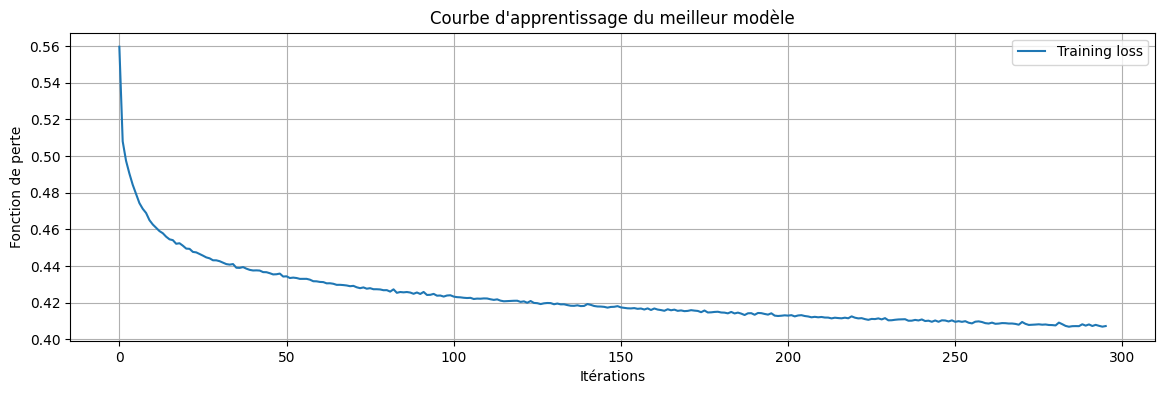

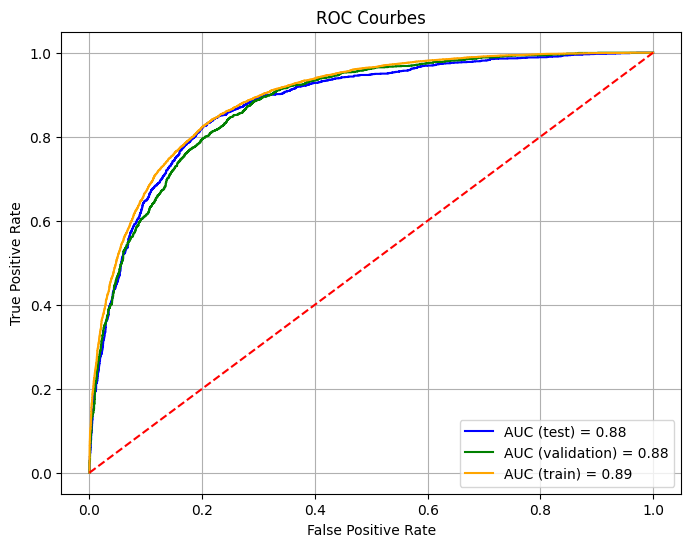

In [18]:
# Évaluation du meilleur modèle sur l'ensemble de test
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nAccuracy with test set: {test_accuracy:.4f}")

# Visualisation de la matrice de confusion
dataframe_confusion_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix for the test set:\n", dataframe_confusion_matrix)


# Courbe d'apprentissage du meilleur modèle
plt.figure(figsize=(14, 4))
plt.plot(best_model.loss_curve_, label='Training loss') # par defaut c'est le train_loss
plt.title('Courbe d\'apprentissage du meilleur modèle')
plt.xlabel('Itérations')
plt.ylabel('Fonction de perte')
plt.legend()
plt.grid(True)
plt.show()

# Courbes ROC pour test, train et validation sur le meme plot
from sklearn.metrics import roc_curve, auc

y_test_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive
y_train_proba = best_model.predict_proba(X_train)
y_val_proba = best_model.predict_proba(X_val)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='blue', label=f'AUC (test) = {roc_auc_test:.2f}')
plt.plot(fpr_val, tpr_val, color='green', label=f'AUC (validation) = {roc_auc_val:.2f}')
plt.plot(fpr_train, tpr_train, color='orange', label=f'AUC (train) = {roc_auc_train:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Courbes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Nota bene:** La variable loss_curve_ du best_model stocke la perte d'entraînement à chaque itération (ou époque) pendant le processus d'entraînement du modèle.

**Remarque:** C'est la matrice de confusion ainsi que la précision calculée pour le modèle choisi une fois que nous avons utilisé la base de données de test qu'on utilise comme indicateurs pour analyser notre modèle MLP finalement. Les courbes "Accuracy de validation pour différentes combinaisons d'hyperparamètres" et "Courbe d'apprentissage du meilleur modèle" sont utilisées pour valider le choix des hyperparamètres fait à la question 3.2. Finalement, les courbes ROC sont utilisées pour voir si la classification est bien faite ou pas (représentation schématique des résultats de la matrice de confusion pour test, train et validation).

## 3.4 Interprétation et analyse

### Matrice de confusion

On observe que nous avons 2638 exemples qui sont normal et qui sont classé correctement comme normal, puis nous avons 400 exemples qui sont normal et qui sont classé comme apnée. De plus, nous avons 547 exemples d'apnée qui sont classé comme normal et finalement nous avons 1321 exemples d'apnée qui sont classé correctement comme apnée.

* Pour la classe "Normal" : Le modèle présente une bonne sensibilité avec 86.8% des cas normaux correctement identifiés (2638/3038), mais il a détecté 400 faux positifs.
* Pour la classe "Apnée" : Le modèle atteint une sensibilité de 70.7% pour détecter l'apnée (1321/1868), avec 547 cas d'apnée marqués comme faux négatifs.

Les 547 faux négatifs (apnées non détectées) représentent un enjeu majeur, car manquer des épisodes d'apnée peut avoir des conséquences graves sur la santé des patients. Cette limitation suggère que le modèle pourrait bénéficier d'un ajustement du seuil de décision pour privilégier la sensibilité à la détection d'apnée.

### Discussion sur la précision sur l'ensemble de la base de donnes 

On avait une precision de 0.8017 pour toute la partie de validation. C'etait en fonction du valeur de precison qu'on avait choisi le model avec la bonne combinaison des hyperparametres.

Maintenant que nous avons utilisé le base de donnes pour les tests, on observe que ce model - ca veut dire ['hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.01] etait aussi le plus perfomant par rapport tous les autres combinaison des hyperparametres, car nous avons obtenu un valeur de précision de 0.8017.

Effectivement les résultats obtenus confirment la robustesse et la validité de notre approche de sélection de modèle. Avec une précision de 0.8017 sur les données d'entraînement/validation et de 0.8070 sur les données de test, nous observons une différence négligeable de seulement 0.0053, ce qui indique que :

* La performance similaire entre les ensembles de validation et de test suggère que le modèle généralise bien aux nouvelles données
* La configuration optimale identifiée reste la plus performante sur des données inédites, validant ainsi notre méthodologie de sélection d'hyperparamètres, qui simplement basé sur la comparaison de la précision pour les differentes models analysés (chaqu'un a differentes hyperparametres)
* Une précision de 80.17% sur l'ensemble de test représente une performance satisfaisante

### Sous-apprentissage / sur-apprentissage

La courbe d'apprentissage montre une convergence de la fonction de perte autour de 0.42 après environ 200 itérations. Effectivement, la performance sur la base de donnes de test (0.8070) est légèrement supérieure à celle de validation (0.8017), avec une différence de +0.0053. Cette amélioration sur l'ensemble des tests indique que le modèle n'est pas en sur-apprentissage car un modèle sur-appris aurait une performance dégradée sur les données test.

### Courbes ROC

Nous utilisons les probabilités pour la classe positive sur les différentes bases de données. Selon le cours, les courbes ROC (Receiver Operating Characteristic) illustrent la performance du classifieur en traçant le taux de vrais positifs (True Positive Rate) en fonction du taux de faux positifs (False Positive Rate) pour différents seuils de décision.

On peut dire que les trois courbes (test, validation et entraînement) sont très proches les unes des autres et montrent une bonne performance. En fait, ces valeurs d'AUC supérieures à 0,85 indiquent une très bonne capacité discriminante du modèle.

Pour conclure, ceux trois courbes ROC (train, test et validation) confirment que le modèle généralise bien et le sur-apprentisage n'est pas detecté. Effectivement les courbes s'eloignent "rapidement" de la diagonale, donc la détection de l'apnée est est efficace.

### Coherence des donnes

On peut conclure que les performances sont très cohérentes entre validation (0.8017) et test (0.8070). En fait, la légère amélioration (+0.53%) sur l'ensemble test est un signe positif qui valide la robustesse de notre sélection d'hyperparamètres et suggère que l'ensemble des tests pourrait être légèrement moins complexe que l'ensemble de validation.

### Efficacité des caractéristiques HRV

Avec une précision de 80.7% sur l'ensemble test, les caractéristiques HRV démontrent une efficacité confirmée pour la détection de l'apnée du sommeil. Nous avons reussi de faire une bonne generalisation qui nous donne une performance stable et reproductible.

Il faut noter comme meme que 29.3% des cas d'apnée manqués (mrqué comme faux négatifs). Donc pour une application clinique, cette sensibilité de 80.7% nécessiterait des améliorations.


# Exercice 4 - Courbes d’apprentissage

## 4.1 Courbes d’entraînement, de précision et de validation

Dans cette exercise nous allons utiliser une configuration MLP different que celui de l'exercise 3 pour essayer observer le sur-apprentisage. Avant on avait 50 neurones, donc le resseau n'etait pas assez profond pour arriver dans le cas du sur-apprentisage comme nous avons observé. Donc les nouveaux hyperparametres pour cette configuration seront (inspiré par la remarque numero 2):

* hidden_layer_sizes : (100, 20, 10) -> pour avoir un resseau plus profond
* activation : tanh -> Meme fonction d'activation que avant
* alpha : 0.0001 -> Taux d'aprentisage plus petit pour que le systeme cherche plus en profondeur 
* solver : adam -> Meme fonction d'optimisation que avant
* batch_size : 32 -> pour augmenter le bruit
* random_state': 42 -> comme avant aussi 
* warm_start : True
* max_iter : 1  -> pour entrainer le systeme epoque par epoque ca veut dire une époque à la fois



In [19]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

# La nouvelle configuration du modele
overfitting_params = {
    'hidden_layer_sizes': (100, 20, 10),  
    'activation': 'tanh',
    'alpha': 0.001, 
    'solver': 'adam',
    'batch_size': 32,
    'random_state': 42,
    'warm_start': True,
    'max_iter': 1 
}

# Nombre d'époques augmenté
n_epochs = 500

# Initialisation
model = MLPClassifier(**overfitting_params)

De plus, avant sur la courble d'apprentisage nous avons bien remarque du bruit. Donc pour lutter contre à ca nous allons utiliser l'astuce du "lissage" pour obtenir une image plus claire et voir la progression réelle.

In [20]:
# Fonction de lissage
def smooth_curve(points, factor=0.9):
    smoothed = []
    for p in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + p * (1 - factor))
        else:
            smoothed.append(p)
    return smoothed

**Nota bene :** Ici on va faire tourner le modele pour tous les epoques et pas pour seulment juste le moment qu'on detecte le sur-apprentisage avec ceux hyperparametres donnees, comme ca on peut tracer les courbes

/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Époque 100: Train loss = 0.3705, Val loss = 0.4591


/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Époque 200: Train loss = 0.3381, Val loss = 0.5055


/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Époque 300: Train loss = 0.3321, Val loss = 0.5837


/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Époque 400: Train loss = 0.3278, Val loss = 0.6415


/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vasilisskarleas/virtual-environments/GTS880/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) 

Époque 500: Train loss = 0.3221, Val loss = 0.6975


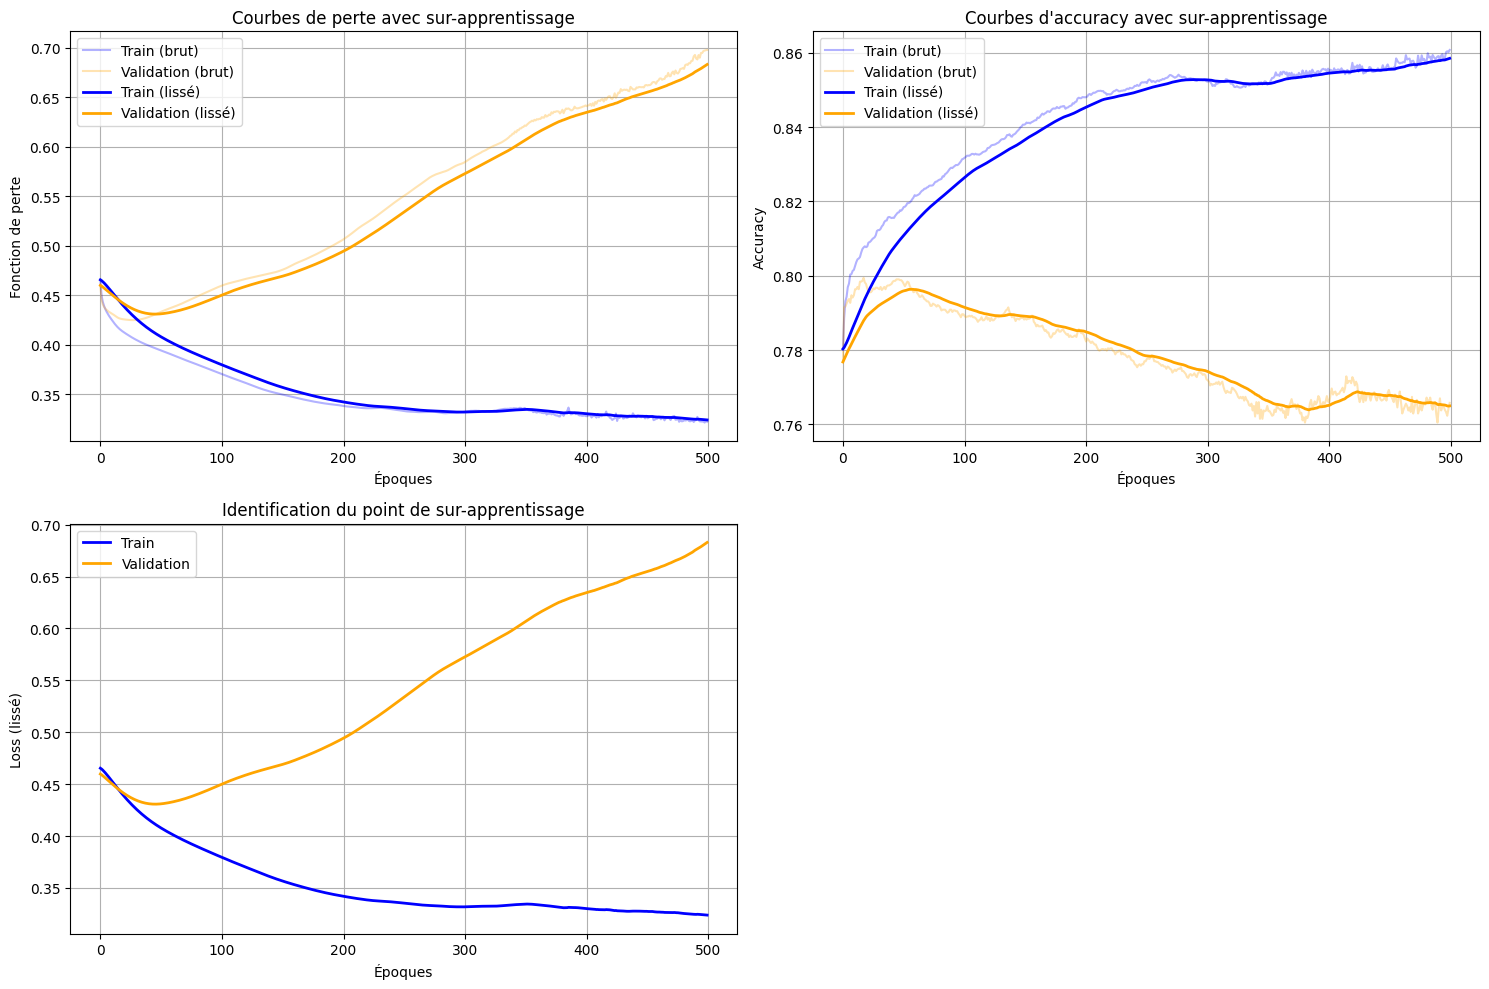

Train set (loss): 0.3221
Validation set (loss): 0.6975
Best validation set (loss): 0.4246 at epoch 27
Test accuracy (after overfitting): 0.7697


In [21]:
# Stockage des results 
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Entraînement époque par époque
for epoch in range(n_epochs):
    # Entraînement d'une époque
    model.fit(X_train, y_train)
    
    # Calcul des pertes (loss)
    y_train_proba = model.predict_proba(X_train)
    y_val_proba = model.predict_proba(X_val)
    
    train_loss = log_loss(y_train, y_train_proba)
    val_loss = log_loss(y_val, y_val_proba)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Sauvegarde des precisions
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_val, model.predict(X_val))
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Affichage progression
    if (epoch + 1) % 100 == 0:
        print(f"Époque {epoch + 1}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}")

# Lissage des courbes
train_losses_smooth = smooth_curve(train_losses, factor=0.95)
val_losses_smooth = smooth_curve(val_losses, factor=0.95)
train_accs_smooth = smooth_curve(train_accs, factor=0.95)
val_accs_smooth = smooth_curve(val_accs, factor=0.95)

# Visualisation
plt.figure(figsize=(15, 10))

# Courbes de perte
plt.subplot(2, 2, 1)
plt.plot(train_losses, alpha=0.3, color='blue', label='Train (brut)')
plt.plot(val_losses, alpha=0.3, color='orange', label='Validation (brut)')
plt.plot(train_losses_smooth, color='blue', linewidth=2, label='Train (lissé)')
plt.plot(val_losses_smooth, color='orange', linewidth=2, label='Validation (lissé)')
plt.xlabel('Époques')
plt.ylabel('Fonction de perte')
plt.title('Courbes de perte avec sur-apprentissage')
plt.legend()
plt.grid(True)

# Courbes de précision
plt.subplot(2, 2, 2)
plt.plot(train_accs, alpha=0.3, color='blue', label='Train (brut)')
plt.plot(val_accs, alpha=0.3, color='orange', label='Validation (brut)')
plt.plot(train_accs_smooth, color='blue', linewidth=2, label='Train (lissé)')
plt.plot(val_accs_smooth, color='orange', linewidth=2, label='Validation (lissé)')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.title('Courbes d\'accuracy avec sur-apprentissage')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)


    
plt.plot(train_losses_smooth, color='blue', linewidth=2, label='Train')
plt.plot(val_losses_smooth, color='orange', linewidth=2, label='Validation')
plt.xlabel('Époques')
plt.ylabel('Loss (lissé)')
plt.title('Identification du point de sur-apprentissage')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyse
print(f"Train set (loss): {train_losses[-1]:.4f}")
print(f"Validation set (loss): {val_losses[-1]:.4f}")
print(f"Best validation set (loss): {min(val_losses):.4f} at epoch {np.argmin(val_losses)}")

# Vérification finale
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy (after overfitting): {test_accuracy:.4f}")

## 4.2 Discussion / interprétation des résultats

### En général

On affiche le résultat de la fonction de perte pour la dernière époque, 0,3221 et 0,6975, pour la base de données d'entraînement et la base de données de validation respectivement. Plus d'informations sont disponibles ci-dessous :

### Sur-apprentisage

On peut observer un sur-apprentissage du modèle entre la 83ème et la 90ème époque. C'est à ce moment que l'écart entre les courbes d'entraînement et de validation commence à s'accentuer de manière significative sur le graphique de perte. En effet, on peut observer que la perte d'entraînement continue de diminuer régulièrement, passant de 0,44 à l'époque 85 jusqu'à 0,32 en fin d'entraînement, tandis que la perte de validation augmente progressivement de 0,45 à 0,70. Cet écart important signifie que le modèle a mémorisé les données d'entraînement plutôt qu'à apprendre des patterns généralisables.

### Early stopping

Il est intéressant de détecter le minimum de la fonction de perte pour la base de données de validation dans le cadre de déterminer à quel moment il aurait fallu arrêter l'entraînement (early stopping). La fonction argmin semble idéale pour la détection de ce dernier car l'argmin d'une fonction est la valeur d'entrée qui produit la valeur minimale de cette fonction, par opposition à la fonction elle-même. Ainsi, il aurait fallu avoir un early stopping à l'époque 27 avec une fonction de perte à 0.4246. On peut dire que la performance sur la validation s'est dégradée après l'époque 27, alors que le modèle continuait à s'améliorer sur les données d'entraînement.

### Les différentes phases

On peut observer trois phases distinctes :

* De 0 à l'époque 27: le modèle est en phase de sous-ajustement caracterisee par des pertes elevees.
* De 27 à l'époque 85: le modèle atteint un équilibre relatif avec une capacité de généralisation optimale, où les courbes d'entraînement et de validation évoluent de manière parallèle avec un écart modéré
* Après l'epoque 85: e modèle entre définitivement en phase de sur-ajustement, avec une divergence exponentiel

### Les résultats

On peut conclure que la précision de 76,97 % obtenue après le sur-apprentissage correspond bien à ce qu'on pouvait anticiper en observant les courbes de précision. Si on avait appliqué l'early stopping à l'époque 27, la précision aurait été meilleure. À noter par contre que nous avons "perdu" seulment 4% de précision même si le modéle qu'on a appliqué ici divirge fortement.

# Exercice 5 - Implémentation de l'arrêt anticipé

Pour repondre à cet exercice, nous avons déjà detecté le numéro de l'epoque qu'il faudrait appliquer l'early stopping à l'exercice 4.Tous les informations sont disponibles ci-dessous à la section early stopping.